# Análise Exploratória de sinais de ECG

In [1]:
import pandas as pd
import numpy as np
import os

PATH = os.path.abspath('../../')
PATH

'/home/davi/Github/doutorado_ppgee_v2'

In [2]:
# df = pd.read_csv(PATH+'/data/Generalized_seizures_dataset.csv')
df = pd.read_csv(PATH + '/data/data_train.csv')

In [3]:
# Quantidade de Sinas por frquência amostral
df['freq'].value_counts()

256     2522
250      687
400      400
512       82
1000      39
Name: freq, dtype: int64

In [4]:
# Contagem de eventos por Arquivo
df['path'].value_counts()

train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.tse      1
train/01_tcp_ar/127/00012742/s007_2015_04_07/00012742_s007_t004.tse      1
train/01_tcp_ar/127/00012742/s005_2015_04_05/00012742_s005_t005.tse      1
train/01_tcp_ar/127/00012742/s005_2015_04_05/00012742_s005_t007.tse      1
train/01_tcp_ar/127/00012742/s005_2015_04_05/00012742_s005_t008.tse      1
                                                                        ..
train/01_tcp_ar/092/00009231/s004_2012_10_07/00009231_s004_t006.tse      1
train/01_tcp_ar/092/00009231/s004_2012_10_07/00009231_s004_t008.tse      1
train/01_tcp_ar/092/00009231/s005_2012_10_07/00009231_s005_t000.tse      1
train/01_tcp_ar/092/00009231/s005_2012_10_07/00009231_s005_t001.tse      1
train/03_tcp_ar_a/131/00013145/s003_2015_09_01/00013145_s003_t003.tse    1
Name: path, Length: 3730, dtype: int64

In [5]:
df = df[df['freq'] == 256].reset_index(drop=True)

In [6]:
files = df['path'].unique()

In [7]:
import os
from dotenv import load_dotenv

load_dotenv()

PATH = os.path.abspath('')

pwd = os.getenv('TUH_PASSWORD')
user = os.getenv('TUH_USER')
path_data = os.getenv('PATH_DATASET')

In [8]:
# Carregando .edf
import mne

file = files[0].replace('tse', 'edf')

data = mne.io.read_raw_edf(path_data + '/' + file)
info = data.info
info

Extracting EDF parameters from /media/davi/2526467b-9f07-4ce5-9425-6d2b458567b7/home/davi/www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.2/edf/train/01_tcp_ar/004/00000458/s011_2014_06_24/00000458_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Info | 7 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 29 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2014-06-24 10:44:41 UTC
 nchan: 29
 projs: []
 sfreq: 256.0 Hz
>

In [9]:
# canais de ecg
ch_ecg = [ch for ch in info.ch_names if 'EKG' in ch]
ch_ecg

['EEG EKG1-REF']

<AxesSubplot:>

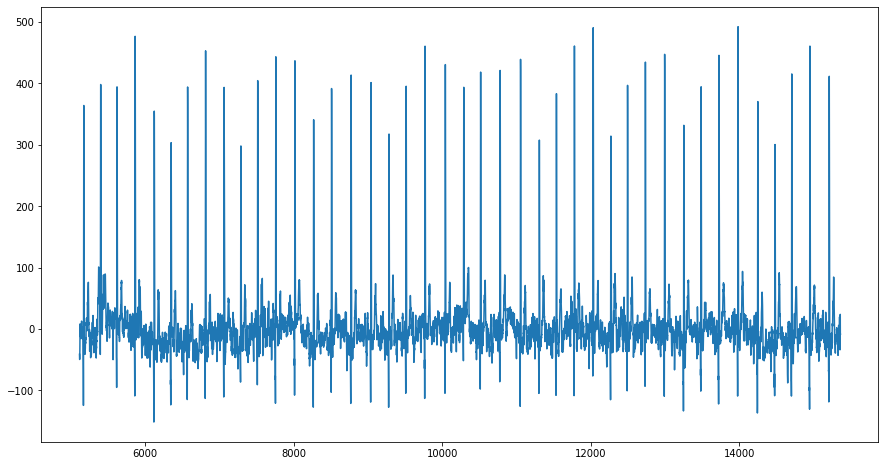

In [10]:
# Canal de ECG puro 

import matplotlib.pyplot as plt

edf = data.to_data_frame()
ecg = edf['EEG EKG1-REF'][256 * 20:256 * 60]*(-1)
fig = plt.figure(figsize=[15, 8])

ecg.plot()

In [11]:
import sys 
new_path = os.path.split(os.getcwd())[0]
sys.path.append(new_path)

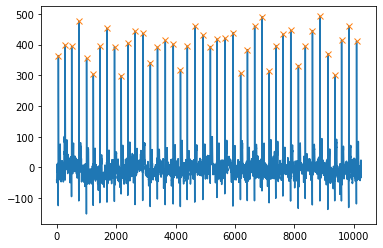

In [12]:
from scipy.signal import find_peaks


x = ecg.to_numpy()

peaks, _ = find_peaks(x, distance=150)

plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [13]:
# from utils import ecg_segmented_beat_modulation as SBM
from utils import ecg_segmented_beat_modulation as SBM

from scipy.signal import find_peaks, butter, filtfilt

x = ecg.to_numpy()


delta_t = 40e-3 
fs = 256
Ts = 1/fs   # Sampling period [s].
gain = 100
f_nyquist = fs / 2
delta_t_n = delta_t * fs

# Time vector.
t = np.arange(0, len(x)*Ts, Ts)

ecg_mV = x/gain 

# Filter parameters.
n = 8 # Desired (effective) order.
f_low = 0.5 # Cut-off frequency 1 (suggested value is 0.5) [Hz]
f_high = 45 # Cut-off frequency 2 (suggested value is 45) [Hz]

# When creating the filter, we will divide the order by 2.
# This is because we will be doing forward and backward filtering later on.
# Thus, we wish to keep the original filter specification.
b, a = butter(round(n/2), [f_low/f_nyquist, f_high/f_nyquist], btype='band')

# Actual filtering.
ecg_pre = filtfilt(b, a, ecg_mV) # [mV]


# Find R peaks.
# Here, we will use a simple thresholding operation.
# However, there are better (i.e., more robust) ways to do so.
peak_threshold = 0.8;
r_peaks, r_peaks_prop = find_peaks(ecg_pre, height=peak_threshold, distance=delta_t_n)

(ecg_clean, mCC, cc_modulated) = SBM.ecg_segmented_beat_modulation_noise_removal(
    ecg_pre, fs, r_peaks, delta_t)


# peaks, _ = find_peaks(x, distance=150)

# d = SBM.ecg_segmented_beat_modulation_noise_removal(
#     ecg=x,fs=256,r_peaks=peaks,delta_t=50)

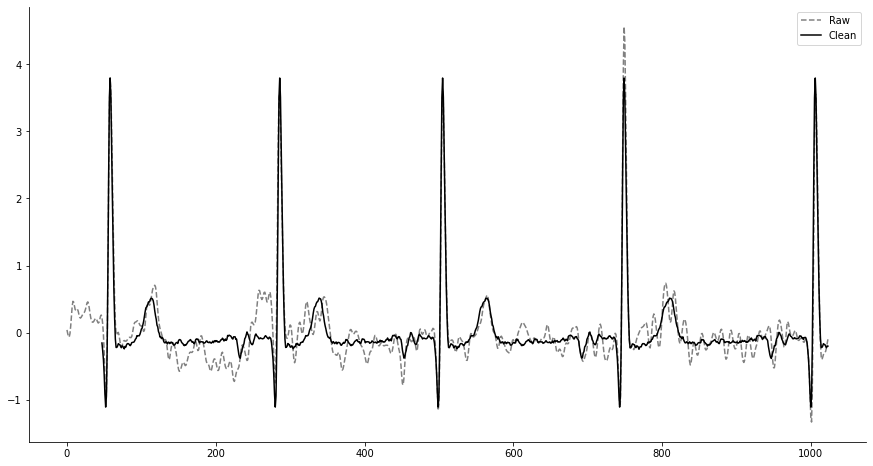

In [20]:
fig = plt.figure(figsize=[15, 8])

ecg_clean2 = np.full_like(ecg_mV, np.nan)
ecg_clean2[int(r_peaks[0]-delta_t_n):int(r_peaks[0]-delta_t_n+len(ecg_clean))] = ecg_clean

plt.plot(ecg_pre[:256*4], '--',color='gray',label='Raw')
# plt.plot(ecg_mV[:256*4],color='black',label='Pre-processed')
plt.plot(ecg_clean2[:256*4],color='black',label='Clean')
plt.legend()

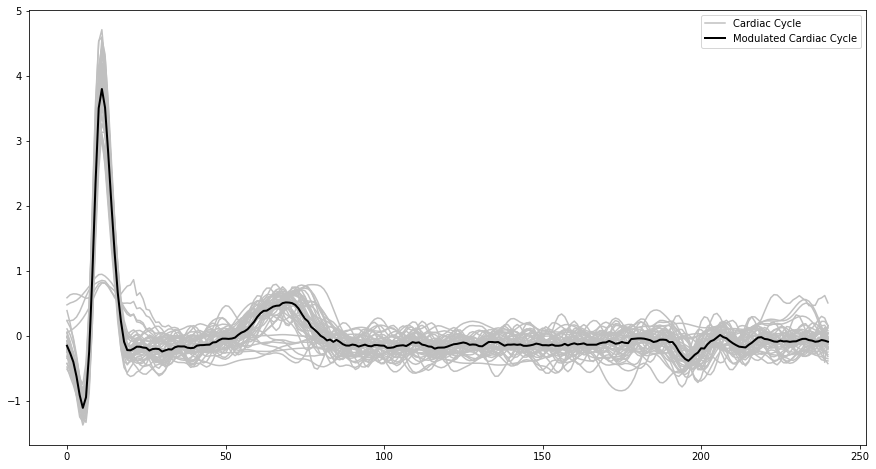

In [15]:
fig = plt.figure(figsize=[15, 8])

for i in range(len(cc_modulated)-1):
    plt.plot(cc_modulated[i],color='silver')
plt.plot(cc_modulated[-1],color='silver',label='Cardiac Cycle')
plt.plot(mCC,color='black',linewidth=2,label='Modulated Cardiac Cycle')
plt.legend()


NameError: name 'PATH_IMAGES' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri


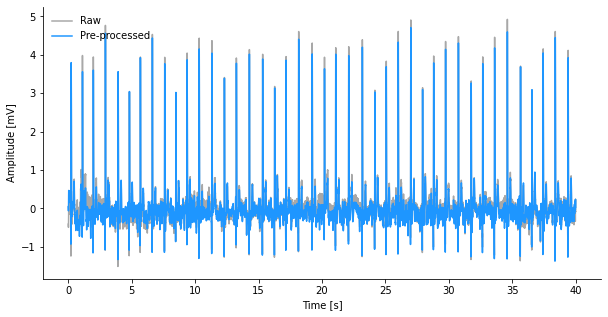

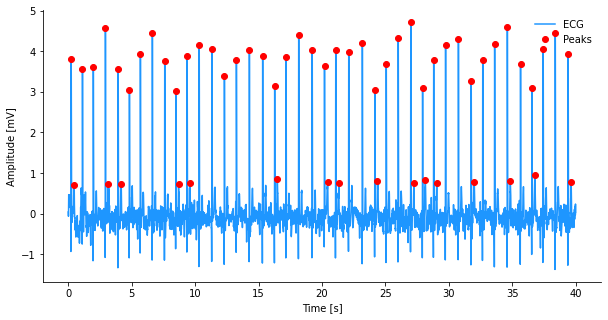

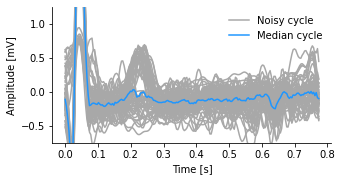

In [16]:
from utils import ecg_segmented_beat_modulation as SBM

SBM.main(ecg.to_numpy())